In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/big/st/strasserl/spapros/docs')

%load_ext autoreload
%autoreload 2

# Spapros Tutorial: Advanced Evaluation.

This tutorial explains the evaluation metrics that are used in the spapros evaluation pipeline and exemplifies how the results can be visualized.

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells for 1838 genes.

**Content**  

0. [Import packages and setup](#0.-Import-packages-and-setup)  
1. [Load dataset](#1.-Load-dataset)  
2. [Set up the ProbesetEvaluator](#2.-Set-up-the-ProbesetEvaluator)
3. [Run evaluation methods](#3.-Run-evaluation-methods)
4. [Visualize the evaluation results](#4.-Visualize-the-evaluation-results)

## 0. Import packages and setup

To run the notebook locally, create a conda environment using this [yaml file](../requirements_dev.yaml):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [2]:
import spapros
from spapros import se, ev, pl
from IPython.display import clear_output
import scanpy as sc
import pandas as pd
import os
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.6 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
spapros==0.1.0


## 1. Load dataset

In [4]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()
adata = adata[adata_tmp.obs_names, adata_tmp.var_names]
adata_raw = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4, key_added="size_factors")
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=1000)
adata.X = adata_raw.X
sc.pp.log1p(adata)
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

## 2. Set up the ProbesetEvaluator

The quality of a selected probeset is not easy to describe. A useful probeset represents both the biological importance and the variability inherent in the total gene set. Spapros provides a set of evaluation metrics that measure the performance in these categories.

By default, `metric_scheme="quick"`, which means that only the faster metrics are calculated, which are:

>- knn
>- forest classification
>- marker correlation (if marker list given: `marker_list="../path/to/marker_list.csv"`)
>- gene correlation

Through setting scheme="full", additionally the following metric is calculated:
>- nmi


Alternatively, you can specify `scheme="custom"` and `metrics=custom_list` where `custom_list` is a list of the metrics of interest.

Below, the metrics will be further explained.

For each evaluation metric, several parameters can be customized. Therefor, the ProbesetEvaluator takes an dictionary containing the parameters as values as `metric_params` argument.
Here, we stored a set of paramets in a yaml file:

In [5]:
# loading metric parameters from file
param_yaml = "../tutorials/data/pbmc3k_parameters.yml"
with open(param_yaml, "r") as file:
    custom_params = yaml.load(file, Loader=yaml.FullLoader)
custom_params

{'data': {'name': 'adata_pbmc3k', 'celltype_key': 'celltype'},
 'metrics': {'cluster_similarity': {'ns': [5, 21],
   'AUC_borders': [[7, 14], [15, 20]]},
  'knn_overlap': {'ks': [5, 10, 15, 20, 25, 30]},
  'forest_clfs': {'ct_key': 'celltype', 'threshold': 0.8},
  'marker_corr': {'per_celltype': True,
   'per_marker': True,
   'per_celltype_min_mean': None,
   'per_marker_min_mean': 0.025},
  'gene_corr': {'threshold': 0.8}}}

In [6]:
# initialize an ProbesetEvaluator
evaluator = ev.ProbesetEvaluator(adata,
#                                  metrics_params=custom_params,
                                 scheme="full",
                                 marker_list="../data/pbmc3k_marker_list.csv",
                                 verbosity=2,
                                 results_dir=None)

## 3.  Run evaluation methods

The principal method for evaluation is `ProbesetEvaluator.evaluate_probeset()`, which needs to be invoked once for each probe set.
All results are stored as class variables.
The `set_id` has to be specified in each iteration. Otherwise, the results will be overwritten.

In [7]:
# select reference probesets with basic selection methods
selections = se.select_reference_probesets(adata, n=50, verbosity=2)

# highly variable genes were only needed for the selection
del adata.var["highly_variable"]

# this is the probeset selected in the standard selection section of the spapros_tutorial_advanced_selection
genes = ['LST1', 'HLA-DPB1', 'HLA-DQA1', 'IL32', 'GZMB', 'CCL5', 'S100A8',
       'GNLY', 'NKG7', 'CD79A', 'TYROBP', 'HLA-DPA1', 'AIF1', 'SAT1', 'LTB',
       'UBXN1', 'CTSW', 'FCER1A', 'FCN1', 'LGALS2', 'IRF8', 'IGFBP7', 'FERMT3',
       'CST3', 'CST7', 'GZMK', 'FGFBP2', 'LYAR', 'VAMP5', 'ATP5A1', 'HLA-DQB1',
       'MS4A6A', 'PSME1', 'ATP5H', 'LAMTOR1', 'PPP1R2', 'CD79B', 'KLRG1',
       'LINC00926', 'TIGIT', 'CCT7', 'PDIA3', 'GIMAP7', 'HLA-DRB1', 'CAPZB',
       'ARF6', 'UBE2L6', 'IGLL5', 'PNRC1', 'OAS1']

# we add it to the dictionary of probesets
selections["spapros_selection"] = pd.DataFrame({"selection": [True if g in genes else False for g in adata.var_names]}, index=adata.var_names)

Output()

In [8]:
# now start the evaluation for each of the collected probesets
for probeset_name, probeset_df in selections.items():
    
    print(probeset_name)
    
    gene_list = probeset_df.index[probeset_df["selection"]].to_list()
    evaluator.evaluate_probeset(gene_list, set_id=probeset_name)
    
    clear_output(wait=True)

Output()

spapros_selection


The following cell types are not included in forest classifications since they have fewer 
than 40 cells: ['Dendritic cells', 'Megakaryocytes']

## 4. Visualize the evaluation results

In [9]:
mpl.rcParams['figure.dpi'] = 60
plt.rcParams["font.size"] = 18

In [10]:
evaluator.summary_results

,cluster_similarity nmi_5_20,cluster_similarity nmi_21_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025
spapros_selection,0.734799,0.57498,0.191625,0.925486,0.98626,0.849805,0.841053,0.683124,0.739218,0.776473


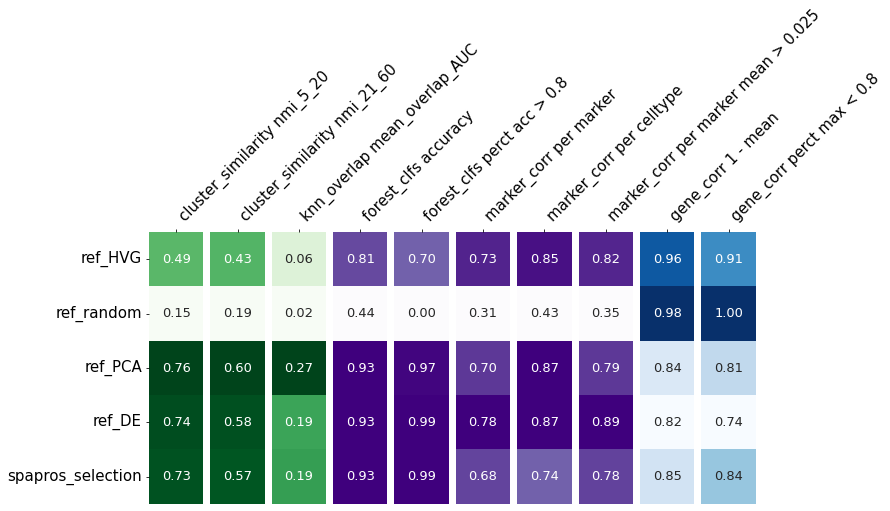

In [11]:
evaluator.summary_statistics(set_ids=selections.keys())
evaluator.plot_summary()

I this plot, each row summarizes the evaluation metrics of one probeset.
The metrics evaluating the variability recovery are shown in the green columns (1-3).
In the first column, you can see the NMI of coarse clusterings of the selected probe set and the full gene set.
Here, for both gene sets clusters with between 5 and 20 clusters were created.
The second column shows the NMI of clusterings from 21 to 60 clusters and thus represents the performance of finer variability recovery.
As the clusterings should picture the heterogeinity of the expression data, a variability recovering subset would would cluster similarly.
Both NMI values are highest for the pca based selection, which indicates that this method recovers the variability best.

The third column reveals the graph overlap of the knn graphs of the full gene set and the respective probeset. If this value is high, it means that fine variations within the full gene set are captured by the probeset.

The subsequent purple columns (4-8) indicate the performance of each selection method with respect to cell type identification.
Column 4 contains the mean classification accuracy of a random forest prediction over cell types. This quantifies the overall classification success while column 5 provides an estimate for the percentage of reliably captured cell types, i.e. the average of a smoothed thresholding of classification performance around 0.8 for each cell type.
The other 3 purple columns (6-8) derive from the comparison of the correlation within the selected probeset with the correlation within the marker list.

The last two, blue columns (9, 10) evaluate the correlation within a selected probeset. If genes with highly correlated expression are selected, the information content could also be provided by just one of them.


In [12]:
mpl.rcParams['figure.dpi'] = 50

Next, we will have a closer look on single evaluation metrics with individual visualizations via the `ProbesetSelector.plot_evaluations` function. 

### Random forest classification

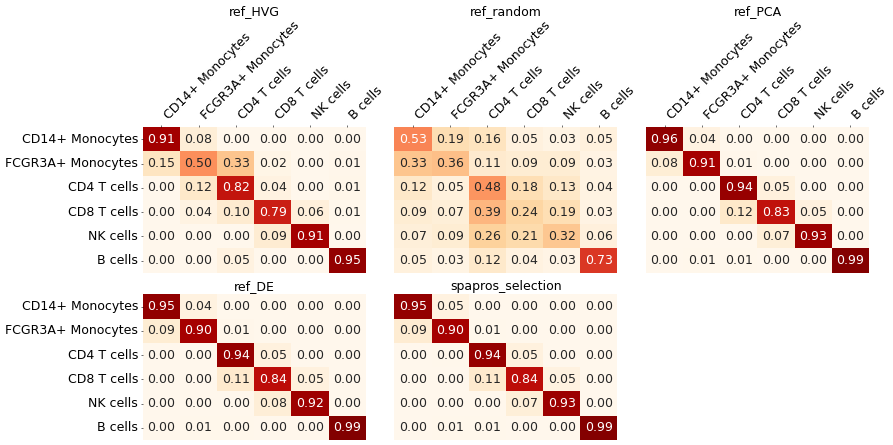

In [13]:
evaluator.plot_confusion_matrix()

### Gene correlation

In [14]:
mpl.rcParams['figure.dpi'] = 40

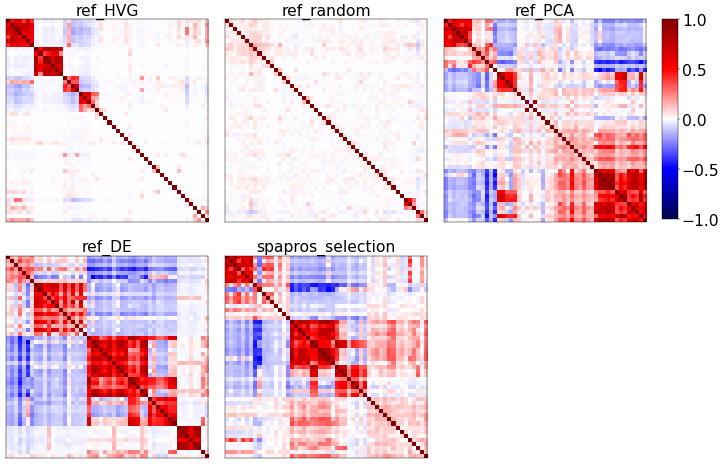

In [15]:
evaluator.plot_correlation_matrix()

### KNN

In [16]:
mpl.rcParams['figure.dpi'] = 45

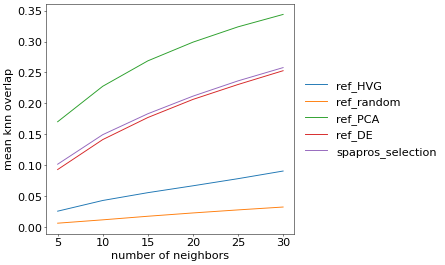

In [17]:
evaluator.plot_knn_overlap()

### NMI cluster similarity

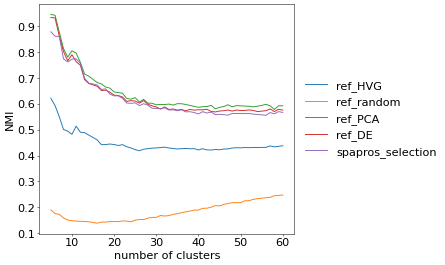

In [18]:
evaluator.plot_cluster_similarity()

### Marker correlation

In [19]:
# TODO